In [4]:
import h5py as h5py 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
import os
print(os.cpu_count())


12


In [7]:
print(os.listdir("nih_data/nih-chest-xrays/data/versions/3/"))

['.ipynb_checkpoints', 'ARXIV_V5_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'Data_Entry_2017.csv', 'Data_Entry_2017_v2020.csv', 'extra', 'FAQ_CHESTXRAY.pdf', 'images_001', 'images_002', 'images_003', 'images_004', 'images_005', 'images_006', 'images_007', 'images_008', 'images_009', 'images_010', 'images_011', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'test_list.txt', 'train_val_list.txt']


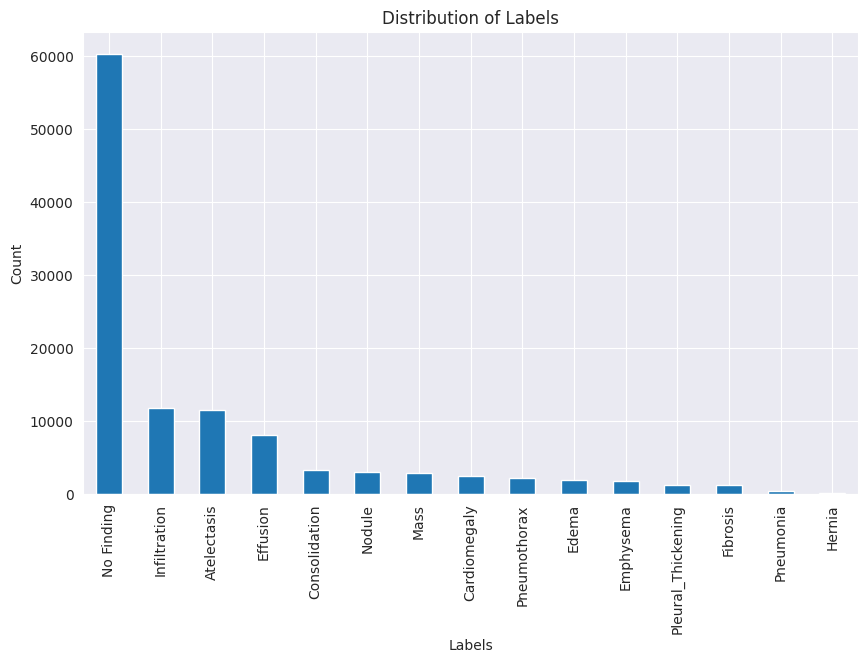

No Finding            60361
Infiltration          11795
Atelectasis           11545
Effusion               8040
Consolidation          3331
Nodule                 3009
Mass                   2926
Cardiomegaly           2404
Pneumothorax           2200
Edema                  1862
Emphysema              1734
Pleural_Thickening     1217
Fibrosis               1215
Pneumonia               325
Hernia                  156
Name: Finding Labels, dtype: int64


In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(r"nih_data/nih-chest-xrays/data/versions/3/Data_Entry_2017.csv")

# Remove the line that replaces 'No Finding'
# df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.split('|')[0])
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.split(','))
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x[0])
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.strip())


plt.figure(figsize=(10,6))
df['Finding Labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Print the count of all labels
print(df['Finding Labels'].value_counts())

In [9]:
# Initialize a dictionary to store the counts
import torch.nn as nn
label_counts = {}
label_map={'Emphysema':0,
           'Effusion':1,
           'Nodule':2,
           'Pneumothorax':3,
           'Atelectasis':4,
           'Pleural_Thickening':5,
           'Mass':6,
           'Edema':7,
           'Consolidation':8,
           'Infiltration':9,
           'Fibrosis':10,
           'Pneumonia':11,
           'No Finding':12
          }
print("Length of labels are :",len(label_map))

# Iterate over the labels
for label in label_map.keys():
    # Count the number of times each label appears in the 'Finding Labels' column
    label_counts[label] = df['Finding Labels'].str.contains(label).sum()

# Calculate class weights
total_count = sum(label_counts.values())
class_weights = {k: total_count/v for k, v in label_counts.items()}

# Convert class weights to tensor
# weights = [class_weights[i] for i in range(len(class_weights))]
# class_weights_tensor = torch.FloatTensor(weights).to(device)

# Convert class weights to tensor
weights = [class_weights[label] for label in label_map.keys()]
class_weights_tensor = torch.FloatTensor(weights).to(device)

# Define your criterion with the class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

# Print the counts and class weights
for label, count in label_counts.items():
    print(f'Label {label}: {count} images, weight: {class_weights[label]}')

Length of labels are : 13
Label Emphysema: 1734 images, weight: 63.18339100346021
Label Effusion: 8040 images, weight: 13.626865671641792
Label Nodule: 3009 images, weight: 36.410767696909275
Label Pneumothorax: 2200 images, weight: 49.8
Label Atelectasis: 11545 images, weight: 9.489822433954092
Label Pleural_Thickening: 1217 images, weight: 90.02465078060806
Label Mass: 2926 images, weight: 37.443609022556394
Label Edema: 1862 images, weight: 58.83995703544576
Label Consolidation: 3331 images, weight: 32.89102371660162
Label Infiltration: 11795 images, weight: 9.288681644764731
Label Fibrosis: 1215 images, weight: 90.17283950617283
Label Pneumonia: 325 images, weight: 337.10769230769233
Label No Finding: 60361 images, weight: 1.8150792730405394


In [10]:
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
class NIH_Chest_Xray_Dataset(Dataset):
    def __init__(self, data_dir, df, label_map, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.df = df
        self.label_map = label_map

        for i, row in self.df.iterrows():
            img_name = row['Image Index']
            labels = row['Finding Labels'].split("|")
            # Only include the image if its label is in label_map
            if any(label in self.label_map for label in labels):
                for i in range(1, 13):
                    img_path = os.path.join(self.data_dir, f'images_{str(i).zfill(3)}/images/', img_name)
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(labels)
                        break

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        labels = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        num_labels = len(self.label_map)
        binary_label = torch.zeros(num_labels)

        for label in labels:
            if label in self.label_map:
                binary_label[self.label_map[label]] = 1

        return img, binary_label

In [11]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
data_dir = 'nih_data/nih-chest-xrays/data/versions/3/'
df = pd.read_csv(os.path.join(data_dir, 'Data_Entry_2017.csv'))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split the DataFrame into a training set and a test set
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Create the train and test datasets 
train_dataset = NIH_Chest_Xray_Dataset(data_dir, train_df, label_map, transform=transform)
test_dataset = NIH_Chest_Xray_Dataset(data_dir, test_df, label_map, transform=transform)

print('DF size (Total) ',len(df))
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))



DF size (Total)  112120
Train dataset size: 99811
Test dataset size: 11104


In [12]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=6, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,  num_workers=6,pin_memory=True)

In [13]:
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import vision_transformer

#model.head = torch.nn.Linear(out_features=14,in_features=768)  #14
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 
#pretrained_vit_weights=torchvision.models.vit_l_16(pretrained=True)

# Setup a ViT model instance with pretrained weights
#model = torchvision.models.vit_l_16(weights=pretrained_vit_weights)
model = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False
    
# change your out_features according to number of classes defined, we have 14 classes 
#model.heads = nn.Linear(in_features=1024, out_features=13)
model.heads = nn.Linear(in_features=768, out_features=13)

model.to(device)  # to put the whole architecture to gpu memory
#print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330M/330M [01:37<00:00, 3.54MB/s]


# run this next code cell for scratch training

In [14]:
# import torch.nn as nn
# import torch.optim as optim
# from torchvision.models import vit_b_16
# from torchvision.models import vit_l_16

# # Setup a ViT model instance without pretrained weights
# model = vit_l_16(pretrained=False)

# # Freeze the base parameters
# for parameter in model.parameters():
#     parameter.requires_grad = False
    
# # Change your out_features according to number of classes defined, we have 14 classes 
# #model.heads = nn.Linear(in_features=768, out_features=13) #for vit_b_16
# model.heads = nn.Linear(in_features=1024, out_features=13) #for vit_l_16

# model.to(device)  # To put the whole architecture to GPU memory
# print(model)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

------------------------------------------------------------------------------------------

In [15]:
from tqdm import tqdm

model.train()
num_epochs = 6

train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies

for epoch in range(num_epochs):
    running_loss = 0.0
    corrects = torch.zeros(13).to(device)  # change torch.zeros(No.classes) according to classes defined above
    total_samples = 0
    
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Calculate training accuracy
        predicted_labels = torch.sigmoid(outputs) > 0.5
        corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += images.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = corrects / total_samples
    
    # Print and save training loss and accuracy
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {}'.format(epoch+1, num_epochs, epoch_loss, epoch_accuracy.tolist()))
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy.tolist())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [4:25:12<00:00,  5.10s/it]


Epoch [1/6], Loss: 1.5287, Accuracy: [0.5728426575660706, 0.5748464465141296, 0.19761349260807037, 0.3925619423389435, 0.6027491688728333, 0.19427718222141266, 0.258859246969223, 0.7039204239845276, 0.5654286742210388, 0.3141537606716156, 0.5011171102523804, 0.07192593812942505, 0.6238089799880981]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [4:47:05<00:00,  5.52s/it]


Epoch [2/6], Loss: 1.4986, Accuracy: [0.6032902002334595, 0.5872699618339539, 0.20717155933380127, 0.4310546815395355, 0.6094719171524048, 0.22037650644779205, 0.2873731255531311, 0.7218543291091919, 0.5757381319999695, 0.3242327868938446, 0.5259139537811279, 0.11134043335914612, 0.6253118515014648]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [4:26:29<00:00,  5.12s/it]


Epoch [3/6], Loss: 1.4960, Accuracy: [0.5964472889900208, 0.5873100161552429, 0.2027031034231186, 0.4366753101348877, 0.6098626255989075, 0.22241035103797913, 0.29212212562561035, 0.7226558327674866, 0.5772610306739807, 0.32561540603637695, 0.5317650437355042, 0.09960825741291046, 0.6257526874542236]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [4:45:41<00:00,  5.49s/it]


Epoch [4/6], Loss: 1.4887, Accuracy: [0.6098025441169739, 0.5881516337394714, 0.21498632431030273, 0.437546968460083, 0.6086102724075317, 0.2374788373708725, 0.29836389422416687, 0.7201110124588013, 0.5790544152259827, 0.32400235533714294, 0.5374157428741455, 0.11563855409622192, 0.6254420876502991]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [4:25:26<00:00,  5.10s/it]


Epoch [5/6], Loss: 1.4924, Accuracy: [0.6083598136901855, 0.5890032052993774, 0.21464568376541138, 0.4389696419239044, 0.6087304949760437, 0.22582681477069855, 0.2869322896003723, 0.7210928797721863, 0.5780324935913086, 0.32367172837257385, 0.5386881232261658, 0.09938783943653107, 0.6258327960968018]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3120/3120 [5:32:08<00:00,  6.39s/it]


Epoch [6/6], Loss: 1.4908, Accuracy: [0.6097323894500732, 0.5873701572418213, 0.21227119863033295, 0.43761709332466125, 0.6090110540390015, 0.22409354150295258, 0.29442647099494934, 0.718998908996582, 0.5783330202102661, 0.32627665996551514, 0.5335684418678284, 0.11231227219104767, 0.6272154450416565]


In [16]:
!df -h /dev/shm


Filesystem      Size  Used Avail Use% Mounted on
none            3.9G  1.8M  3.9G   1% /dev/shm


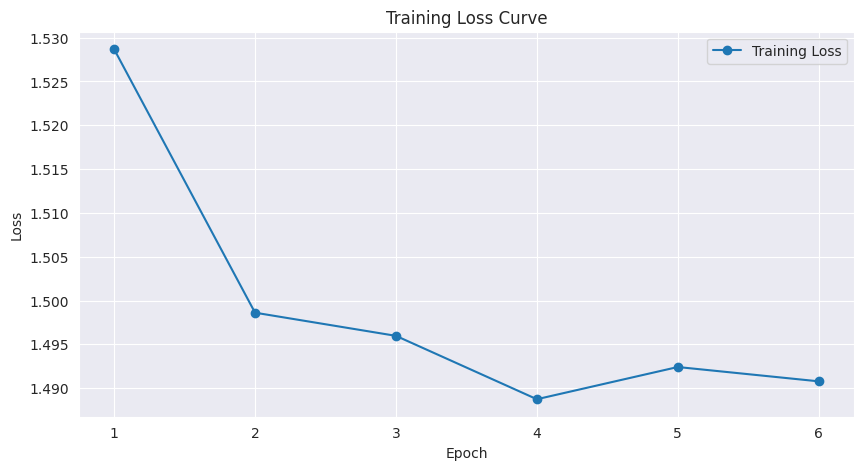

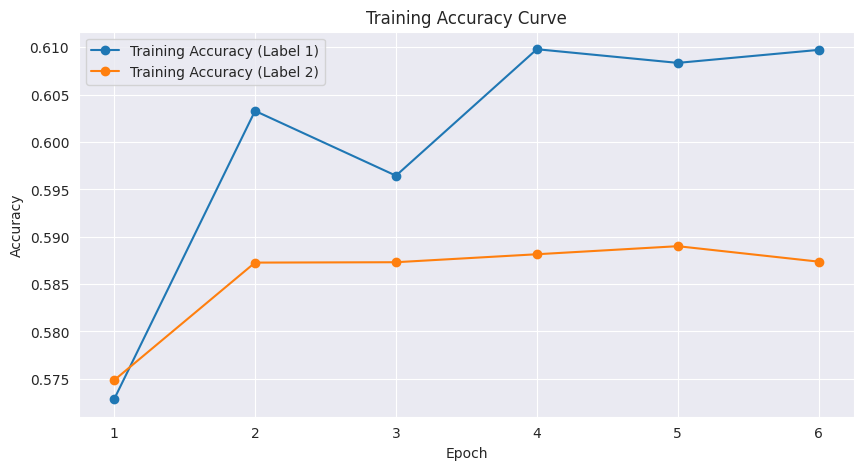

In [17]:
import matplotlib.pyplot as plt

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy curve
plt.figure(figsize=(10, 5))
for i in range(2):  # Plot accuracy for each label
    plt.plot(range(1, num_epochs+1), [acc[i] for acc in train_accuracies], marker='o', label=f'Training Accuracy (Label {i+1})')

plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
torch.save(model.state_dict(), 'weights.pth')

In [31]:
import os


# Create the directory if it doesn't exist
save_path = 'nih_data/vit_weights'
os.makedirs(save_path, exist_ok=True)

# Save the model weights
weights_file = os.path.join(save_path, 'weights.pth')
torch.save(model.state_dict(), weights_file)

print(f"Model weights saved to {weights_file}")


Model weights saved to nih_data/vit_weights/weights.pth


In [19]:
#Evaluate
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt

model.eval()
auc_scores = []    
running_loss = 0.0
running_corrects = torch.zeros(13).to(device)
total_samples = 0
num_labels = 13  # change lables here
with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        predicted_labels = torch.sigmoid(outputs) > 0.5
        predicted_probs = torch.sigmoid(outputs)
                
        running_corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += inputs.size(0)
        y_pred.append(predicted_probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

epoch_loss = running_loss / total_samples
epoch_acc = running_corrects / total_samples
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
auc_score = roc_auc_score(y_true, y_pred, average='macro')

#auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr') 
print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [32:43<00:00,  5.66s/it]


Validation Loss: 1.4990 | Validation Acc: [0.3619416356086731, 0.37896254658699036, 0.3275396227836609, 0.6300432085990906, 0.5739372968673706, 0.09212896227836609, 0.1858789622783661, 0.5365633964538574, 0.6221181750297546, 0.39139050245285034, 0.26954251527786255, 0.05115273594856262, 0.6377881765365601] | AUC score: 0.7444


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 347/347 [30:02<00:00,  5.19s/it]


{'Emphysema': {'precision': 0.032160110420979986, 'recall': 0.9708333333333333, 'f1-score': 0.062257849031396126, 'support': 240}, 'Effusion': {'precision': 0.1609702315325248, 'recall': 0.9726128793486306, 'f1-score': 0.276224511246584, 'support': 1351}, 'Nodule': {'precision': 0.06890012642225031, 'recall': 0.8847402597402597, 'f1-score': 0.12784424114473375, 'support': 616}, 'Pneumothorax': {'precision': 0.0964478417266187, 'recall': 0.8281853281853282, 'f1-score': 0.17277486910994763, 'support': 518}, 'Atelectasis': {'precision': 0.1606587374199451, 'recall': 0.789568345323741, 'f1-score': 0.26699102934468605, 'support': 1112}, 'Pleural_Thickening': {'precision': 0.030466122056703508, 'recall': 0.990625, 'f1-score': 0.059114219114219116, 'support': 320}, 'Mass': {'precision': 0.0586145648312611, 'recall': 0.9705882352941176, 'f1-score': 0.11055276381909547, 'support': 578}, 'Edema': {'precision': 0.03908305148440436, 'recall': 0.9327354260089686, 'f1-score': 0.07502254283137962, 's

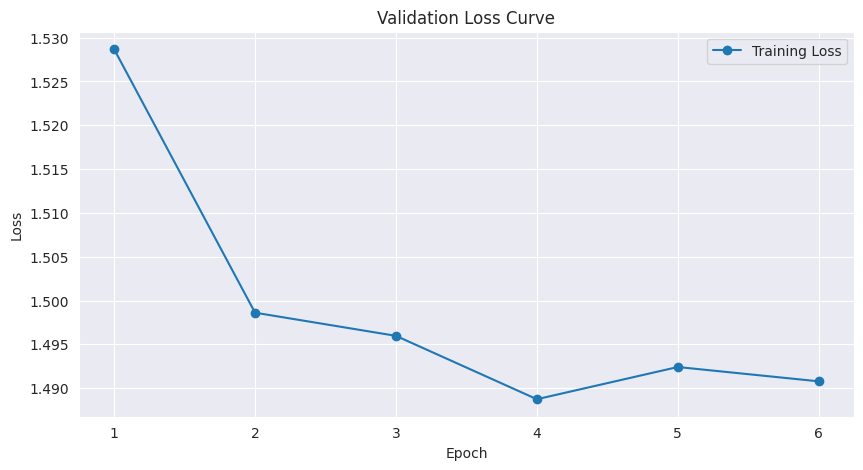

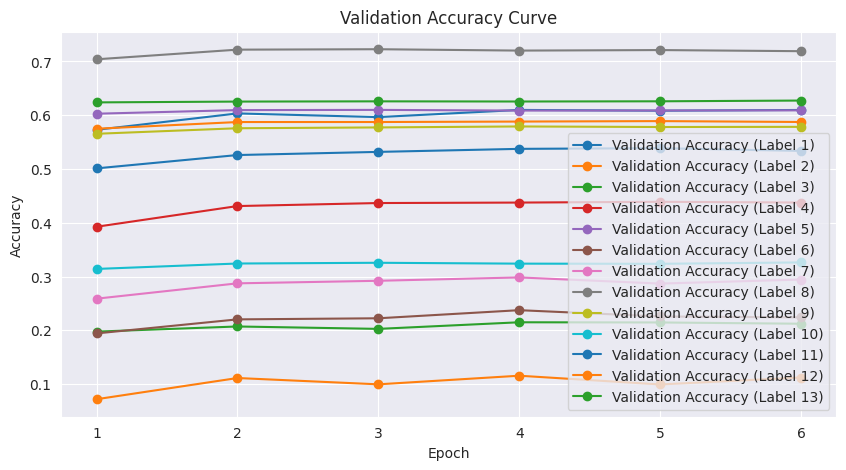

In [20]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


model.eval()
auc_scores = []    
running_loss = 0.0
running_corrects = torch.zeros(13).to(device)
total_samples = 0
num_labels = 13  # Change the number of labels here

with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        predicted_labels = torch.sigmoid(outputs) > 0.5
        predicted_probs = torch.sigmoid(outputs)
                
        running_corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += inputs.size(0)
        y_pred.append(predicted_probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
    auc_score = roc_auc_score(y_true, y_pred, average='macro')

    
    
# Convert probabilities to class labels
    y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate and print the classification report
    report = classification_report(y_true, y_pred_labels, target_names=label_map.keys(), output_dict=True)
    print(report)

# Calculate and print the average F1 score, recall, and specificity
    avg_f1 = np.mean([report[label]['f1-score'] for label in label_map.keys()])
    avg_recall = np.mean([report[label]['recall'] for label in label_map.keys()])
    avg_specificity = np.mean([1 - report[label]['recall'] for label in label_map.keys()])

    print(f'Average F1 Score: {avg_f1}')
    print(f'Average Recall: {avg_recall}')
    print(f'Average Specificity: {avg_specificity}')

# Print validation loss, accuracy, and AUC score
    print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')


    # Print validation loss, accuracy, and AUC score
    print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')

    # Plotting accuracy and loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
    plt.title('Validation Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(num_labels):  # Plot accuracy for each label
        plt.plot(range(1, num_epochs+1), [acc[i] for acc in train_accuracies], marker='o', label=f'Validation Accuracy (Label {i+1})')

    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

   

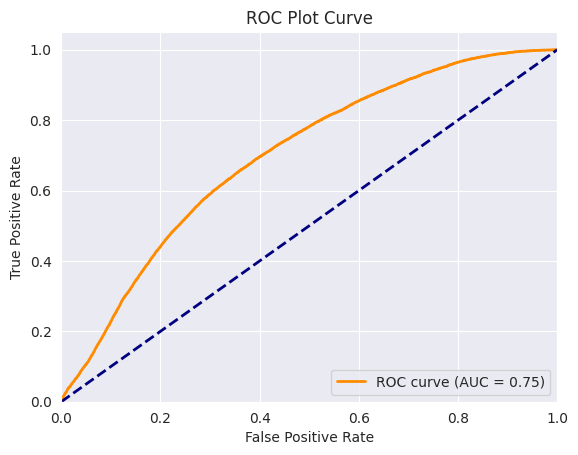

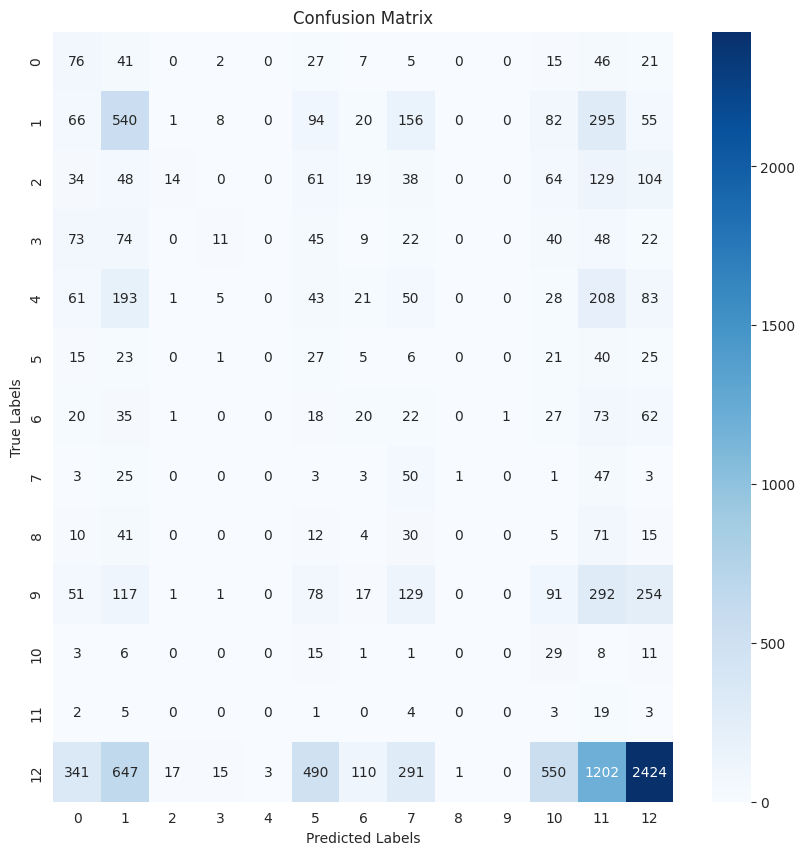

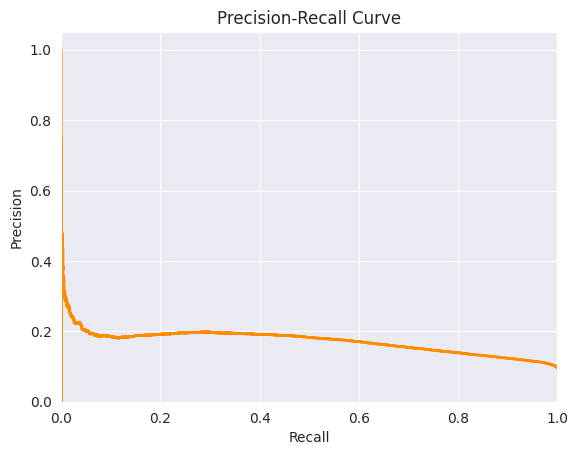

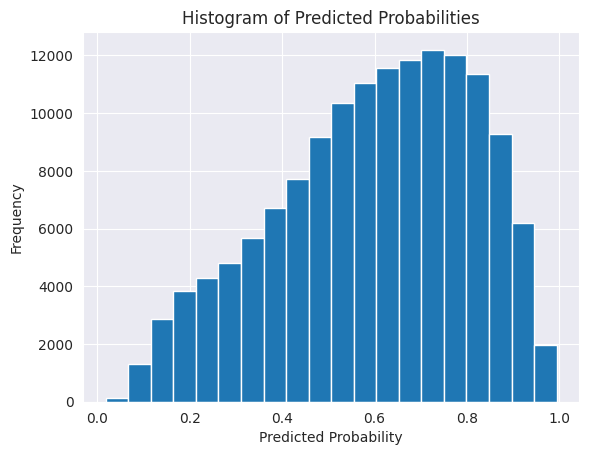

In [32]:
# plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Plot Curve')
plt.legend(loc="lower right")
plt.show()


# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Convert lists to numpy arrays
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true_np.argmax(axis=1), y_pred_np.argmax(axis=1))

conf_mat = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Histogram of predicted probabilities
plt.figure()
plt.hist(y_pred.ravel(), bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

In [22]:
!pip install grad-cam

In [23]:
!pip install timm

In [24]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import timm
#from your_module import ViT_B_16  # Import your ViT model
from torchvision.models import vision_transformer as vit
from torchvision.models import vision_transformer
from pytorch_grad_cam import GradCAM    
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

if __name__ == '__main__':
    use_cuda = torch.cuda.is_available()
    image_path = r'nih_data/nih-chest-xrays/data/versions/3/images_004/images/00006585_008.png'
    aug_smooth = False
    eigen_smooth = False
    method = 'gradcam'

    if use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')

    # Load your ViT model
    #model = ViT_B_16(pretrained=True) 
    # Adjust the parameters accordingly
    #model = vit.vit_base_patch16_224(pretrained=True)
    # Get pretrained weights for ViT-Base
    pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with pretrained weights
    #model = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
    model = timm.create_model('vit_base_patch16_224', pretrained=True)  # Adjust the parameters accordingly

    model.eval()

    if use_cuda:
        model = model.cuda()

    target_layers = [model.blocks[-1].norm1]

    methods = {"gradcam": GradCAM}

    if method not in list(methods.keys()):
        raise Exception(f"method should be one of {list(methods.keys())}")

    if method == "ablationcam":
        cam = methods[method](model=model,
                              target_layers=target_layers,
                              reshape_transform=reshape_transform,
                              ablation_layer=AblationLayerVit())
    else:
        cam = methods[method](model=model,
                              target_layers=target_layers,
                              reshape_transform=reshape_transform)

    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

    targets = None

    cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=eigen_smooth,
                        aug_smooth=aug_smooth)

    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    cv2.imwrite(f'{method}_cams8.jpg', cam_image)
    #cv2.imshow(f'{method}_cams.jpg', cam_image)


Using CPU for computation
